# グラフ作成用
## 制約、環境のパラメタ

In [1]:
g_0 = 9.8 # m/s2

deltaV = 7000 # m/s
m_L = 2000 # kg
a_0 = 0.3 * g_0
r_s = 0.3 # g/cm3
f_inerts = 0.1
T_0 = 298.15 # K
T_i = 300 # K

r = 7/5
R_0 = 8.314 # J/(molK) = kJ/(kmolK)
c_p = r / (r-1) * R_0

eta_j = 0.96
p_a = 10 * 1000 # Pa

ts = 10/1000 # s

## 推進剤に関して決定するパラメタ

In [2]:
W_o = 38# 単位[g/mol]
r_o = 1.51# 単位[g/cm3]
deltaH_o = 0# 単位は[J/mol]


W_f = 2# 単位[g/mol]
r_f = 0.071# 単位[g/cm3]
deltaH_f =0 # 単位[J/mol]

# 生成物の物性
W_p = {'HF': 20} # 単位[g/mol]
deltaH_p = {'HF': -271.2e3}# 単位[J/mol]

mixture_ratio = 19# 無次元量

## 燃焼室のパラメタ

In [3]:
p_0 = 10e6# 単位[Pa]
k = 5# 燃焼器スロート断面積比A1/At
d_t = 2# タンク直径 単位[m]

## グラフ生成

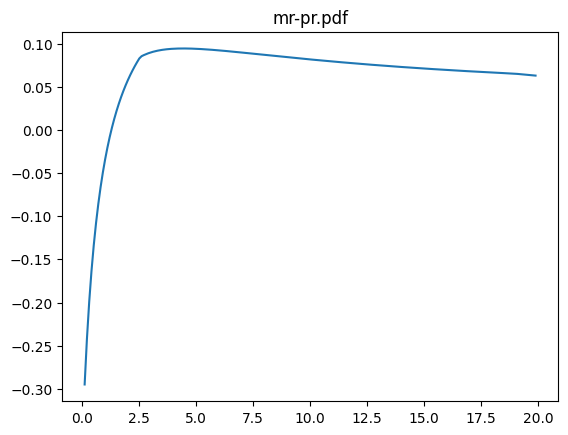

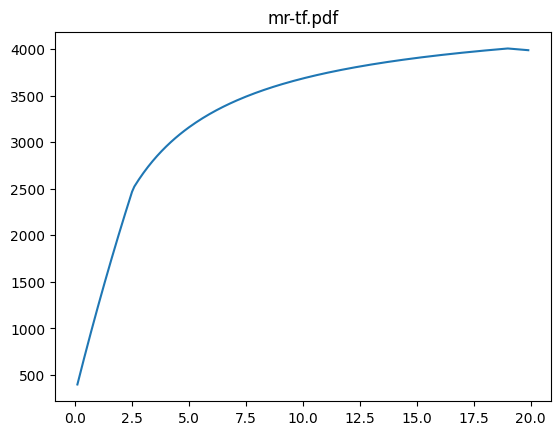

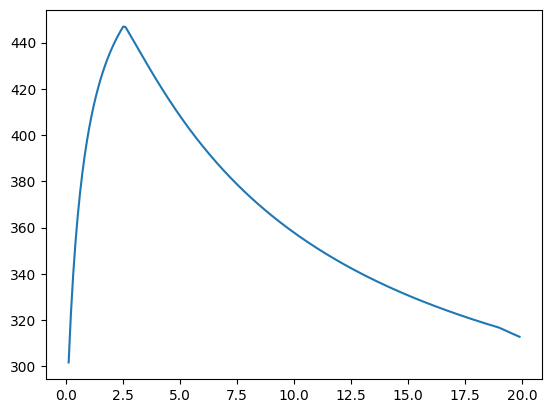

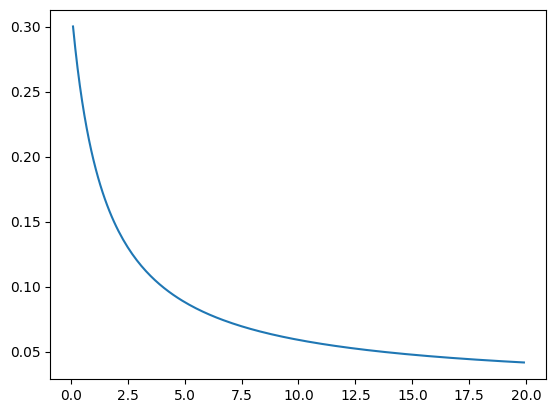

In [9]:
import math
import matplotlib.pyplot as plt

mixture_ratio = 0.1
mrMax         = 20
dmr           = 0.1

MR     = []
PR     = []
TF     = []
ISP    = []
FINERT = []

while mixture_ratio < mrMax:
  #mole_fraction = 0.0
  #rho = 0.0
  #f_inert = 0.0
  #T_f = 0.0
  #W = 0.0
  #T_t = 0.0
  #p_a = 0.0
  #C_p = 0.0
  #Isp = 0.0
  #payload_ratio = 0.0
  #M_total = 0.0
  #F = 0.0
  #C_F = 0.0
  #A_t = 0.0
  #L_s = 0.0
  #d_cc = 0.0

  MR.append(mixture_ratio)

  def get_mole_fraction():
    return mixture_ratio * W_f / W_o
  mole_fraction = get_mole_fraction()

  def get_rho():
    return (1+mixture_ratio)/((1/r_f)+(mixture_ratio/r_o)) # 単位[]
  rho = get_rho()

  def get_f_inert():
    return ((1/f_inerts-1)*rho/r_s+1)**(-1) # 無次元量
  f_inert = get_f_inert()

  FINERT.append(f_inert)
  
  theoritical_coeff_ratio = {"H2": 1, "F2": 1, "HF": 2} # 酸化剤を1にする
  n_o = ("F2", 1) # 1で固定
  n_f = ("H2", 1/mixture_ratio * W_o/W_f)

  rest_n_f = 0
  rest_n_o = 0
  n_p = theoritical_coeff_ratio.copy()
  n_p.pop(n_f[0])
  n_p.pop(n_o[0])
  
  # fuel rich
  if theoritical_coeff_ratio[n_f[0]] < n_f[1]:
    rest_n_f = n_f[1] - theoritical_coeff_ratio[n_f[0]]
    rest_n_o = 0
  # oxidizer rich
  else:
    rest_n_f = 0
    rest_n_o = 1 - n_f[1]/theoritical_coeff_ratio[n_f[0]]
    for key in n_p.keys():
        n_p[key] = n_p[key] * n_f[1]/theoritical_coeff_ratio[n_f[0]]

  def get_A():
    return n_o[1] * deltaH_o + n_f[1] * deltaH_f
  
  def get_B():
    ret = 0
    for key, val in deltaH_p.items():
        ret += n_p[key] * val
    return ret
  
  def get_a():
    return c_p*(sum(list(n_p.values())) + rest_n_o + rest_n_f)
  
  def get_b():
    return  c_p*(n_o[1] + n_f[1] * (T_0 - T_i)) - c_p * (rest_n_o + rest_n_f + sum(list(n_p.values())) ) * T_0

  def get_T_f():
    A = get_A()
    B = get_B()
    a = get_a()
    b = get_b()
    T_f_test = (A-B-b)/a
    if T_f_test <= 2500:
        return T_f_test
    return 2500*(A-2*B-b)/(2500*a-B)
  T_f = get_T_f()

  TF.append(T_f)

  def get_W():
    ret = 0
    for key, val in W_p.items():
        ret += n_p[key] * val
    ret += rest_n_o * W_o + rest_n_f * W_f
    ret /= (sum(list(n_p.values())) + rest_n_o+ rest_n_f)
    return ret
  W = get_W()/1000 # 単位[kg/mol]

  def get_T_t():
    return T_f / ((r+1)/2)
  T_t = get_T_t()

  p_e = p_a

  def get_R():
    return R_0/W
  R = get_R()

  def get_C_p():
    return r/(r-1)*R
  C_p = get_C_p()
  
  def get_Isp():
    V_j = math.sqrt(2*eta_j*C_p*T_f*(1-(p_e/p_0)**((r-1)/r)))
    return V_j / g_0
  Isp = get_Isp()

  ISP.append(Isp)

  def get_payload_ratio():
    return (math.exp(-deltaV/(g_0*Isp))-f_inert)/(1-f_inert)
  payload_ratio = get_payload_ratio()

  PR.append(payload_ratio)

  #def get_M_total():
  #  return m_L / payload_ratio
  #M_total = get_M_total()

  #def get_F():
  #  return M_total * g_0 * (1+0.3)
  #F = get_F()

  #def get_C_F():
  #  return math.sqrt(2*r**2/(r-1)*(2/(r+1))**((r+1)/(r-1))*(1-(p_e/p_0)**((r-1)/r)))
  #C_F = get_C_F()
  
  #def get_A_t():
  #  return F / (p_0*C_F)
  #A_t = get_A_t()

  #def get_L_s():
  #  return ts/(((r+1)/2)**((r+1)/(2*(r-1)))/math.sqrt(r*R*T_f))
  #L_s = get_L_s()

  #def get_d_cc():
  #  A_1 = k * A_t
  #  L = L_s / k
  #  return math.sqrt(4*A_1/math.pi)
  #d_cc =  get_d_cc()

  #def get_l_t():
  #  m_p = (1-f_inert)*(1-payload_ratio)*M_total
  #  V_p = m_p / (rho*1000)
  #  return V_p / (math.pi*(d_t/2)**2)
  #l_t = get_l_t()

  mixture_ratio += dmr

plt.plot(MR,PR)
plt.title("mr-pr.pdf")
# plt.clf()
plt.show()

plt.plot(MR,TF)
plt.title("mr-tf.pdf")
plt.show()

# plt.clf()
plt.plot(MR,ISP)
plt.show()

# plt.clf()
plt.plot(MR,FINERT)
plt.show()
# plt.clf()
